<a href="https://colab.research.google.com/github/reckn/super-disco/blob/main/Terra_Store_Interactive_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 *The code below will simulate the behaviour of terra store customers given certain conditions. Even though I've tried my best to write a code that running efficient, please be aware that from the moment you click "start simulation" until the plot is shown the process may take some time. Patience! :D For the first time you run the cell (code), it take about 1 minute. For slider value around > 1M it could take more than 1 minute.*


IntSlider(value=3000000, description='Number of Interactions:', max=5000000, min=1000, step=1000)

IntSlider(value=3000000, description='Number of Purchase History:', max=5000000, min=1000, step=1000)

IntSlider(value=1043, description='Number of Products:', max=2000, min=10, step=10)

IntSlider(value=5000000, description='Total Customers:', max=10000000, min=1000, step=1000)

Button(description='Start Simulation', style=ButtonStyle())

 
/* output */
All Customer IDs in purchase_history_df are also present in customer_interactions_df.
Number of unique IDs in purchase_history_df: 1000


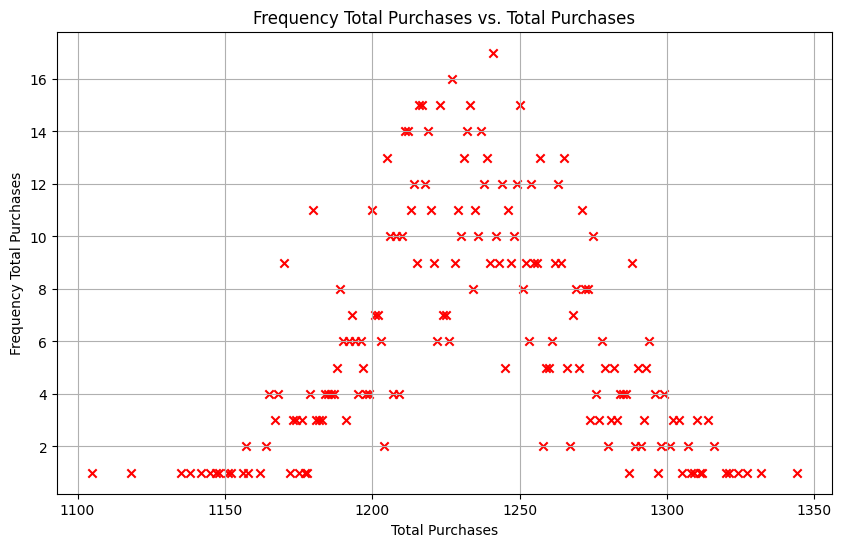

Execution time: 27.66916537284851 seconds


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Button, Output

PRICE_RANGES = {
    "Apparel and Fashion Accessories": (10, 500),
    "Electronics": (20, 5000),
    "Beauty and Personal Care Products": (5, 200),
    "Home and Kitchen Appliances": (20, 2000),
    "Books and Media": (5, 100),
    "Consumer Electronics Accessories": (5, 200),
    "Health and Wellness Products": (5, 500),
    "Toys and Games": (5, 300),
    "Pet Supplies": (5, 300),
    "Sporting Goods and Fitness Equipment": (10, 2000)
}

def generate_random_customer_ids(num_interactions, total_customers):
    """Generate random unique customer IDs for interactions."""
    if num_interactions > total_customers:
        raise ValueError("Number of interactions cannot exceed total customers.")

    return np.random.choice(np.arange(1, total_customers + 1), num_interactions, replace=False)


def generate_customer_interactions(num_interactions, customer_ids, purchase_history_df):
    """Generate customer interactions data."""
    max_page_views = purchase_history_df.groupby('Customer ID')['Page Views'].sum()
    max_page_views = max_page_views.reindex(customer_ids, fill_value=1)
    num_page_views = np.random.randint(max_page_views, max_page_views + 100, size=num_interactions)

    time_spent = np.random.uniform(1, 5, size=num_interactions)
    while np.any(time_spent / num_page_views <= 0.733):
        mask = time_spent / num_page_views <= 0.733
        time_spent[mask] += np.random.uniform(5, 20, size=mask.sum())

    return pd.DataFrame({
        'Customer ID': customer_ids,
        'Page Views': num_page_views,
        'Time Spent (minutes)': np.round(time_spent)
    })

def generate_product_details(num_products):
    """Generate product details."""
    categories = np.random.choice(list(PRICE_RANGES.keys()), num_products)
    prices = [np.random.uniform(*PRICE_RANGES[cat]) for cat in categories]
    return pd.DataFrame({
        'Product ID': range(1, num_products + 1),
        'Category': categories,
        'Price': prices,
        'Ratings': np.round(np.random.uniform(1, 5, num_products), 1)
    })

def generate_purchase_history(customer_ids, num_purchase_history, product_details_df):
    """Generate purchase history."""
    product_ids = np.random.choice(product_details_df['Product ID'], num_purchase_history)
    categories = product_details_df.set_index('Product ID').loc[product_ids, 'Category'].values
    prices = product_details_df.set_index('Product ID').loc[product_ids, 'Price'].values
    purchase_dates = np.array([datetime.now() - timedelta(
        days=np.random.randint(1, 365),
        hours=np.random.randint(0, 24),
        minutes=np.random.randint(0, 60),
        seconds=np.random.randint(0, 60)
    ) for _ in range(num_purchase_history)])
    page_views = np.random.randint(1, 5, num_purchase_history)

    return pd.DataFrame({
        'Customer ID': np.random.choice(customer_ids, num_purchase_history),
        'Product ID': product_ids,
        'Purchase Date': purchase_dates,
        'Category': categories,
        'Price': prices,
        'Page Views': page_views
    })

def save_to_csv(customer_interactions_df, purchase_history_df, product_details_df):
    """Save dataframes to CSV files."""
    customer_interactions_df.to_csv('customer_interactions_synthetic.csv', index=False)
    purchase_history_df.to_csv('purchase_history_synthetic.csv', index=False)
    product_details_df.to_csv('product_details_synthetic.csv', index=False)

def start_simulation(b):
    num_interactions = num_interactions_slider.value
    num_purchase_history = num_purchase_history_slider.value
    num_products = num_products_slider.value
    total_customers = total_customers_slider.value

    start_time = time.time()

    customer_ids = generate_random_customer_ids(num_interactions, total_customers)

    product_details_df = generate_product_details(num_products)
    purchase_history_df = generate_purchase_history(customer_ids, num_purchase_history, product_details_df)
    customer_interactions_df = generate_customer_interactions(num_interactions, customer_ids, purchase_history_df)

    save_to_csv(customer_interactions_df, purchase_history_df, product_details_df)

    print(" ")
    print("/* output */")

    # Check for Customer IDs in purchase_history_df but not in customer_interactions_df
    missing_customer_ids = set(purchase_history_df['Customer ID']) - set(customer_interactions_df['Customer ID'])

    if missing_customer_ids:
        print("Customer IDs present in purchase_history_df but not in customer_interactions_df:")
        print(missing_customer_ids)
    else:
        print("All Customer IDs in purchase_history_df are also present in customer_interactions_df.")

    # Count the number of unique IDs in 'Customer ID' column of 'purchase_history_df'
    unique_ids_count = purchase_history_df['Customer ID'].nunique()

    # Print the count of unique IDs
    print("Number of unique IDs in purchase_history_df:", unique_ids_count)

    # Plotting
    # Count the frequency of each ID
    id_frequency = purchase_history_df['Customer ID'].value_counts()

    # Count the frequency of the frequencies of IDs
    id_frequency_frequency = id_frequency.value_counts()

    # Plot frequency distribution of frequency of the ID vs. frequency of the frequency of the ID
    plt.figure(figsize=(10, 6))
    plt.scatter(id_frequency_frequency.index, id_frequency_frequency.values, color='red', marker='x')
    plt.title('Frequency Total Purchases vs. Total Purchases')
    plt.xlabel('Total Purchases')
    plt.ylabel('Frequency Total Purchases')
    plt.grid(True)
    plt.show()

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

# Interactive sliders
num_interactions_slider = IntSlider(min=1000, max=5000000, step=1000, value=3000000, description='Number of Interactions:')
num_purchase_history_slider = IntSlider(min=1000, max=5000000, step=1000, value=3000000, description='Number of Purchase History:')
num_products_slider = IntSlider(min=10, max=2000, step=10, value=1043, description='Number of Products:')
total_customers_slider = IntSlider(min=1000, max=10000000, step=1000, value=5000000, description='Total Customers:')

# Button for starting the simulation
start_button = Button(description='Start Simulation')
start_button.on_click(start_simulation)

# Display the widgets
display(num_interactions_slider, num_purchase_history_slider, num_products_slider, total_customers_slider, start_button)
